In [2]:
import pandas as pd
import numpy as np
import pandas_datareader as wb
import matplotlib.pyplot as plt


In [3]:
# Single stock
'''
Use this cell if you want to use the single stock data part of this notebook. 
The cell below can be used for multiple stocks 
'''

tickers = ['HEIA.AS']

In [ ]:
# Multi stock
'''
Use this cell if you want to use the multiple stock data part of this notebook. 
The cell above can be used for single stocks 
'''

tickers = ['RDSA.AS', 'REN.AS', 'AD.AS', 'WKL.AS', 'DSM.AS', 'MT.AS', 
'PHIA.AS', 'KPN.AS', 'ASML.AS', 'ASM.AS', 'ABN.AS', 'GLPG.AS', 'AGN.AS',
'NN.AS', 'UNA.AS', 'AKZA.AS', 'HEIA.AS', 'RAND.AS', 'INGA.AS' ]

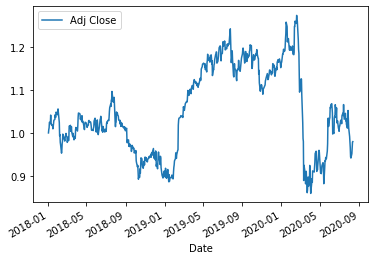

In [5]:

start_date = '2018-01-01'

# Request tickers data
def get_data(tickers=tickers, start_date=start_date, fix_date=False):
    '''
    Gets stock data from the Yahoo API.

    Inputs:
        tickers: The stock tickers that you want to get data from
        start_date: The starting date from which you want your data
        fix_date: Set this to true if you want to use ...

    Output:
        df: the data frame with all the data
    '''
    
    if len(tickers) == 1:
        df = wb.DataReader(tickers[0], 'yahoo', start_date)
    else:
        df = wb.DataReader(tickers, 'yahoo', start_date)

    # Optional fix datetime index
    if fix_date:
        df.index = pd.DatetimeIndex(df.index).to_period('D')

    # Plot normalised returns
    (df['Adj Close'] / df['Adj Close'].iloc[0]).plot()
    plt.legend(loc=2)
    plt.show()

    return df

df = get_data()

In [6]:
def feature_engineering(df=df, tickers=tickers):
    '''
    Adds features to the data frame in 3 parts. The first part adds lags of the returns (1 to 5 days),
    the second part adds a 'high minus low' spread which is the highest price of a stock minus the lowest.
    This represents volatility. 1 to 3 days lags are made of this HL spread after which the HL spread 
    is removed because it holds information about the day which we want to predict (the current day). 
    The last part adds a categorical return variable that is 1 if stock return is positive and 0 otherwise.

    Input:
        df: The date frame to apply feature engineering to
        tickers: The tickers that the df contains

    Output:
        df: the data frame with added features
    
    '''
    if len(tickers) == 1:
        # Return column
        df['Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

        # 1-5 day lags
        df['1_day_lag'] = df['Returns'].shift(1)
        df['2_day_lag'] = df['Returns'].shift(2)
        df['3_day_lag'] = df['Returns'].shift(3)
        df['4_day_lag'] = df['Returns'].shift(4)
        df['5_day_lag'] = df['Returns'].shift(5)

        #High-Low spread
        df['HL_spread'] = (df['High'] - df['Low']) / df['Close']
        df['HL_lag_1'] = df['HL_spread'].shift(1)
        df['HL_lag_2'] = df['HL_spread'].shift(2)
        df['HL_lag_3'] = df['HL_spread'].shift(3)
        df.drop('HL_spread', axis=1, inplace=True)

        # Categorical return (1 if > 0 and 0 otherwise)
        df['Cat_return'] = np.multiply(df['Returns'] > 0, 1)
    else:
        for tick in tickers:
            # Return column
            df['Returns', tick] = np.log(df['Adj Close', tick] / df['Adj Close', tick].shift(1))

            # 1-5 day lags
            df['1_day_lag', tick] = df['Returns', tick].shift(1)
            df['2_day_lag', tick] = df['Returns', tick].shift(2)
            df['3_day_lag', tick] = df['Returns', tick].shift(3)
            df['4_day_lag', tick] = df['Returns', tick].shift(4)
            df['5_day_lag', tick] = df['Returns', tick].shift(5)

            #High-Low spread
            df['HL_spread', tick] = (df['High', tick] - df['Low', tick]) / df['Close', tick]
            df['HL_lag_1', tick] = df['HL_spread', tick].shift(1)
            df['HL_lag_2', tick] = df['HL_spread', tick].shift(2)
            df['HL_lag_3', tick] = df['HL_spread', tick].shift(3)
            df.drop('HL_spread', axis=1, inplace=True)

            # Categorical return (1 if > 0 and 0 otherwise)
            df['Cat_return', tick] = np.multiply(df['Returns', tick] > 0, 1)

    # Drop nan's 
    df.dropna(axis=0, inplace=True)

    #df = df.stack()

    print('Number of trading days (rows): ', df.shape[0])

    return df

df = feature_engineering()

df.tail()

Number of trading days (rows):  661


,High,Low,Open,Close,Volume,Adj Close,Returns,1_day_lag,2_day_lag,3_day_lag,4_day_lag,5_day_lag,HL_lag_1,HL_lag_2,HL_lag_3,Cat_return
Date,,,,,,,,,,,,,,,,
2020-08-07,76.820000,75.959999,76.500000,76.500000,452953.0,76.500000,-0.002872,-0.022426,-0.012413,-0.014000,-0.020640,-0.017358,0.018509,0.023451,0.018630,0
2020-08-10,77.320000,76.400002,77.000000,77.320000,455361.0,77.320000,0.010662,-0.002872,-0.022426,-0.012413,-0.014000,-0.020640,0.011242,0.018509,0.023451,1
2020-08-11,79.199997,77.620003,77.639999,78.459999,628403.0,78.459999,0.014636,0.010662,-0.002872,-0.022426,-0.012413,-0.014000,0.011899,0.011242,0.018509,1
2020-08-12,79.580002,78.019997,78.480003,79.540001,486168.0,79.540001,0.013671,0.014636,0.010662,-0.002872,-0.022426,-0.012413,0.020138,0.011899,0.011242,1
2020-08-13,79.639999,78.820000,79.300003,79.599998,132353.0,79.599998,0.000754,0.013671,0.014636,0.010662,-0.002872,-0.022426,0.019613,0.020138,0.011899,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 660 entries, 2018-01-10 to 2020-08-12
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   High        660 non-null    float64
 1   Low         660 non-null    float64
 2   Open        660 non-null    float64
 3   Close       660 non-null    float64
 4   Volume      660 non-null    float64
 5   Adj Close   660 non-null    float64
 6   Returns     660 non-null    float64
 7   1_day_lag   660 non-null    float64
 8   2_day_lag   660 non-null    float64
 9   3_day_lag   660 non-null    float64
 10  4_day_lag   660 non-null    float64
 11  5_day_lag   660 non-null    float64
 12  HL_lag_1    660 non-null    float64
 13  HL_lag_2    660 non-null    float64
 14  HL_lag_3    660 non-null    float64
 15  Cat_return  660 non-null    int32  
dtypes: float64(15), int32(1)
memory usage: 85.1 KB


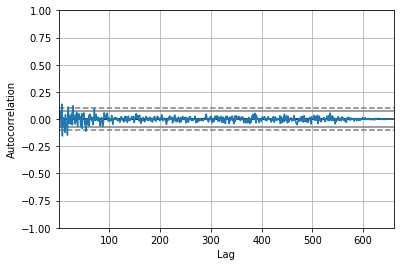

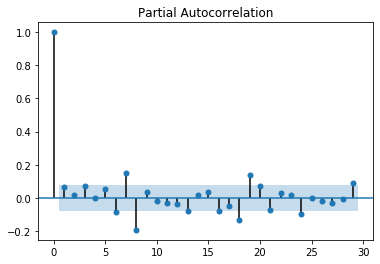

In [11]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf

# Autocorrelation
autocorrelation_plot(df['Returns'])
plt.show()

# Partial autocorrelation
plot_pacf(df['Returns'])
plt.show()

C:\Users\a_arj\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


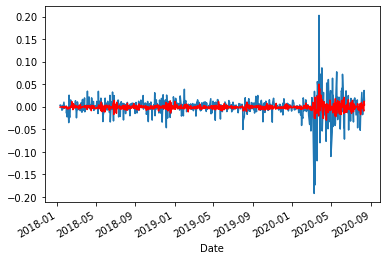

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
pd.plotting.register_matplotlib_converters()

model = ARIMA(df['Returns'], order=(2, 0, 10))
results = model.fit(disp=-1)

df['Returns'].plot()
plt.plot(results.fittedvalues, color='red')
plt.show()

In [49]:
def single_stock_algorithm(predictions, capital=100_000, t_cost=1, short=False):
    '''
    Can use predictions made on the X_test data set for a naive trading algorithm. 
    If prediction > 0 it will buy the stock and if shorting is allowed will do the
    opposite. 

    Input:
        predictions: The predictions on the X_test data set to be used
        capital: How much capital is put into the stock (default 100.000)
        t_cost: transaction cost (default of 1)
        short: True if shorting is allowed and false (default) if not
    '''

    num_trade = 0

    zipper = zip(y_test, predictions)

    for ret, pred in zipper:
        if pred > 0:
            capital = (1 + ret) * capital - t_cost * 2
            num_trade += 1
        if short:
            if pred < 0:
                capital = (1 - ret) * capital - t_cost * 2
                num_trade += 1

    print('Waarde:', round(capital), 'Euro')
    print('Winst:', int(capital) - 100_000, 'Euro')
    print('Number of trades:', num_trade)
    print('Transaction cost:', num_trade * t_cost * 2, end='\n\n')



In [59]:
single_stock_algorithm(rf_preds, short=True)

Waarde: 119512 Euro
Winst: 19511 Euro
Number of trades: 132
Transaction cost: 264



In [35]:
X = df[['1_day_lag', '2_day_lag', '3_day_lag',
        '4_day_lag', '5_day_lag', 
        #'HL_lag_1', 'HL_lag_2','HL_lag_3'
        ]]
y = df['Returns']
y_cat = df['Cat_return']

df_len = X.shape[0]
test_size = 0.2 

X_test = X.tail(int(df_len * test_size))
X_train = X.head(int(df_len * (1 - test_size)))

y_test = y.tail(int(df_len * test_size))
y_train = y.head(int(df_len * (1 - test_size)))

y_cat_test = y_cat.tail(int(df_len * test_size))
y_cat_train = y_cat.head(int(df_len * (1 - test_size)))


In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#instantiate linear model
lm = LinearRegression()

#fit the model to the training set
lm.fit(X_train, y_train)

#predict using the test set and training set
lm_preds = lm.predict(X_test)

#score the two predictions above
score_test = r2_score(y_test, pred_test)

#create a new table with coefficiencts found by the model
coefs = pd.DataFrame()
coefs['feature'] = X.columns
coefs['coefficient'] = lm.coef_
coefs['absolute coef'] = np.abs(lm.coef_)

#sort the coefficients from large to small and add an extra row with the intercept at 
#the bottom of the table
coefs = coefs.sort_values('absolute coef', ascending=False)
coefs = coefs.append({'feature':'Intercept', 'coefficient':lm.intercept_, \
                      'absolute coef':np.abs(lm.intercept_)}, ignore_index=True)

print(coefs, end='\n\n')

lm_error = np.mean(abs(pred_test - y_test))

print("Average error:", round(lm_error, 3))
print("R2-score of the model on the test data:", round(score_test,3))

feature  coefficient  absolute coef
0  5_day_lag     0.099937       0.099937
1  4_day_lag    -0.080981       0.080981
2  3_day_lag    -0.074535       0.074535
3  1_day_lag    -0.023523       0.023523
4  2_day_lag    -0.004960       0.004960
5  Intercept     0.000292       0.000292

Average error: 0.016
R2-score of the model on the test data: -0.025


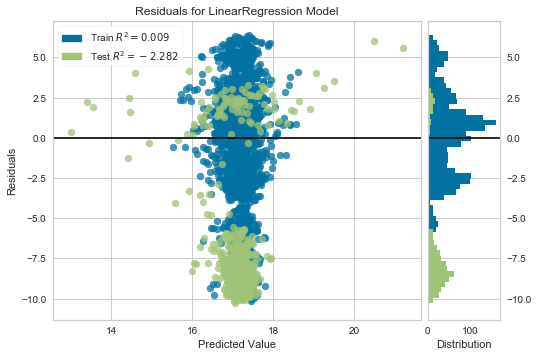

In [26]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lm)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

#instantiate the Random Forest regressor
rf = RandomForestRegressor(n_estimators = 10, n_jobs=2)

#fit the model to the training set
rf.fit(X_train, y_train)

#predict on the test set
rf_preds = rf.predict(X_test)

#score the prediction
rf_r2_score = r2_score(y_test, rf_preds)

#calculate average error between prediction and known y-value
rf_error = np.mean(abs(rf_preds - y_test))

#print results
print("Average error:", round(rf_error, 3))
print("R2-score of the model on the test data:", round(rf_r2_score,3))

Average error: 0.017
R2-score of the model on the test data: -0.063


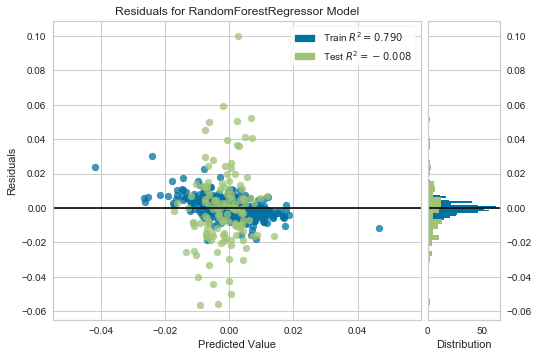

In [41]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(rf)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

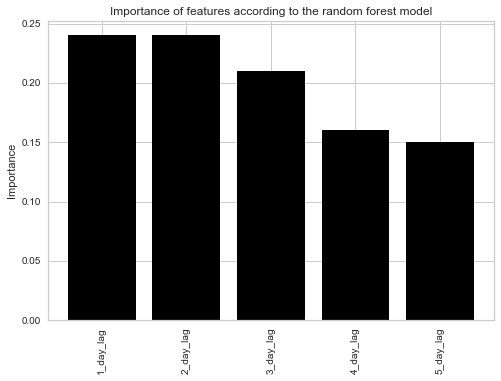

In [42]:
importance = list(rf.feature_importances_.round(2))
importance.sort(reverse=True)
features = list(X.columns)

x_values = np.array(list(range(len(importance))))
plt.bar(features, importance, color='black')
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.title('Importance of features according to the random forest model')
plt.show()

In [43]:
single_stock_algorithm(rf_preds, short=True)

Waarde: 103042 Euro
Winst: 3041 Euro
Number of trades: 132
Transaction cost 264



In [11]:
from sklearn.svm import SVC

clf = SVC(gamma='scale')
clf.fit(X_train, y_cat_train)
svc_pred = clf.predict(X_test)

print('Accuracy: ' + str(int((y_cat_test== svc_pred).sum() / len(y_cat_test) * 100)) + '%')

Accuracy: 52%


In [12]:
# Baseline prediction which assumes positive returns every day
all_one = [1] * len(y_cat_test)
print('Accuracy: ' + str(int((y_cat_test == all_one).sum() / len(y_cat_test) * 100)) + '%')

Accuracy: 49%


In [13]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=1000, n_jobs=2)
clf_rf.fit(X_train, y_cat_train)

clf_rf_pred = clf_rf.predict(X_test)

print('Accuracy: ' + str(int((y_cat_test == clf_rf_pred).sum() / len(y_cat_test) * 100)) + '%')

Accuracy: 51%


In [191]:
high_vol_df = df.reset_index(level=['Date', 'Symbols'])
high_vol_days = list()

for idx, ret in enumerate(high_vol_df['1_day_lag']):
    if abs(ret) > 0.02:
        high_vol_days.append(idx)

high_vol_df = high_vol_df[high_vol_df.index.isin(high_vol_days)]
high_vol_df.head()

In [149]:
'''
New dependent and independent variables with high volatility
'''

X = high_vol_df[['1_day_lag', '2_day_lag', '3_day_lag',
        #'4_day_lag', '5_day_lag', 
        'HL_lag_1', 'HL_lag_2','HL_lag_3']]
y = high_vol_df['Returns']
y_cat = high_vol_df['Cat_return']

df_len = X.shape[0]
test_size = 0.2 

X_test = X.tail(int(df_len * test_size))
X_train = X.head(int(df_len * (1 - test_size)))

y_test = y.tail(int(df_len * test_size))
y_train = y.head(int(df_len * (1 - test_size)))

y_cat_test = y_cat.tail(int(df_len * test_size))
y_cat_train = y_cat.head(int(df_len * (1 - test_size)))

print(len(y_test))

461


In [20]:
# Naive trading algorithm. If the stock went up yesterday, go long. If the stock went down, go short
transactie_kosten = 2

buy_n_hold_total = 0
strat_total = 0 

starting_capital = 1000_00

for tick in tickers:
    capital = starting_capital
    num_trade = 0

    zipper = zip(df['Returns'][tick], df['1_day_lag'][tick])

    for ret, lag in zipper:
        # Long
        if lag > 0:
            capital = (1 + ret) * capital - transactie_kosten
            num_trade += 1
        # Short
        elif lag < 0:
            capital = (1 - ret) * capital - transactie_kosten
            num_trade += 1    

    strat_total += capital
    buy_n_hold = df['Adj Close'][tick].iloc[-1] / df['Adj Close'][tick].iloc[0] * starting_capital
    buy_n_hold_total += buy_n_hold

    print(tick)
    print(int(buy_n_hold), 
    'Euro with buy en hold')
    print(int(capital), 'Euro with our strategy')
    print('in', num_trade, 'Trades', end='\n\n')  

RDSA.AS
56585 Euro with buy en hold
325610 Euro with our strategy
in 660 Trades

REN.AS
110945 Euro with buy en hold
49438 Euro with our strategy
in 648 Trades

AD.AS
162099 Euro with buy en hold
93902 Euro with our strategy
in 650 Trades

WKL.AS
165698 Euro with buy en hold
89901 Euro with our strategy
in 648 Trades

DSM.AS
171073 Euro with buy en hold
86224 Euro with our strategy
in 649 Trades

MT.AS
36173 Euro with buy en hold
101680 Euro with our strategy
in 659 Trades

PHIA.AS
147132 Euro with buy en hold
72744 Euro with our strategy
in 657 Trades

KPN.AS
90840 Euro with buy en hold
50709 Euro with our strategy
in 646 Trades

ASML.AS
213089 Euro with buy en hold
83111 Euro with our strategy
in 656 Trades

ASM.AS
250798 Euro with buy en hold
43834 Euro with our strategy
in 656 Trades

ABN.AS
39639 Euro with buy en hold
107759 Euro with our strategy
in 653 Trades

GLPG.AS
182388 Euro with buy en hold
212419 Euro with our strategy
in 657 Trades

AGN.AS
65668 Euro with buy en hold
105

In [22]:
total_start_cap = len(tickers) * starting_capital
print(total_start_cap)
print('Buy n hold winst:', int(buy_n_hold_total) - total_start_cap, 'Euro')
print('Strat winst:', int(strat_total) - total_start_cap, 'Euro')

1900000
Buy n hold winst: 390132 Euro
Strat winst: 170225 Euro
